# PREPARAZIONE DATASET 

In [1]:
import xml.etree.ElementTree as ET

def process_frames_with_tracks(pairs):
    """
        Serve per poter costruire una lista di dizionari con le informazioni
            derivate dai file XML cosi come sono.
        
        :Params
            :file_pairs = è una lista di coppie (x,y)
                 dove x è il file xml relativo al video i-esimo, mentre y è l'id del video.
        
        :Returns
            restituisce una lista di dizionari.
    """
    all_frame_data = []

    for xml_file, index in pairs:

        print(f"Processing file:{xml_file} of video: ID-{index} ...")
        
        tree = ET.parse(xml_file)
        root = tree.getroot()

        total_frames = int(root.find(".//meta/task/size").text)

        frame_data = []

        for track in root.findall(".//track"):
            track_id = track.get("id")
            label = track.get("label")

            if label == "ball":
                for points in track.findall("points"):
                    
                    frame = int(points.get("frame"))
                    
                    outside = int(points.get("outside"))
                    occluded = int(points.get("occluded"))
                    
                    coords = points.get("points").split(",")
                    
                    x, y = float(coords[0]), float(coords[1])

                    used_in_game = None
                    attribute = points.find("attribute[@name='used_in_game']")
                    
                    if attribute is not None:
                        used_in_game = attribute.text
                        
                    # Ci aggiugiamo le info al dizionario
                    frame_info = {
                        "num_frame": frame,
                        "target": "balls",
                        "posx": x,
                        "posy": y,
                        "id": index,
                        "track_id": track_id,
                        "outside":outside,
                        "occluded":occluded,
                        "used_in_game":int(used_in_game)
                    }
                    
                    frame_data.append(frame_info)
                    
        #Per le istanze che non sono rilevanti [non compaiono nell'XML]
        all_frames = set(range(total_frames)) 
        tracked_frames = {entry["num_frame"] for entry in frame_data}

        for frame in all_frames - tracked_frames:
            frame_info = {
                "num_frame": frame,
                "target": "noballs",
                "posx": None,
                "posy": None,
                "id": index,
                "track_id": None,
                "outside":None,
                "occluded":None,
                "used_in_game": 0
            }
            frame_data.append(frame_info)

        # Ordina per numero di frame
        frame_data.sort(key=lambda x: x["num_frame"])

        all_frame_data.extend(frame_data)

    print("All files elaborated!")
    return all_frame_data

file_and_index = [
    (f"/kaggle/input/computer-vision-futbal/dataset_soccer/dataset_soccer/train/ID-{i}.xml",i)
    for i in range(1, 5)
]

data = process_frames_with_tracks(file_and_index)

print("Starting cleaning result...")
#Dobbiamo sistemare le seguenti istanze nel risultato poichè non utili per i nostri scopi.
for entry in data:
  if entry['outside']==1 or entry['used_in_game']==0:
    entry['target'] = 'noballs'
    entry['posx'] = None
    entry['posy'] = None
print("Result cleaned.")

Processing file:/kaggle/input/computer-vision-futbal/dataset_soccer/dataset_soccer/train/ID-1.xml of video: ID-1 ...
Processing file:/kaggle/input/computer-vision-futbal/dataset_soccer/dataset_soccer/train/ID-2.xml of video: ID-2 ...
Processing file:/kaggle/input/computer-vision-futbal/dataset_soccer/dataset_soccer/train/ID-3.xml of video: ID-3 ...
Processing file:/kaggle/input/computer-vision-futbal/dataset_soccer/dataset_soccer/train/ID-4.xml of video: ID-4 ...
All files elaborated!
Starting cleaning result...
Result cleaned.


In [2]:
from collections import defaultdict

def aggregate_instances(data):
    
    """
        Questa funzione aggrega le istanze di frame duplicati presenti nei dati XML. 
        Se ci sono più istanze per lo stesso frame (ad esempio due palloni), vengono unificate 
        in una sola riga nel dizionario.
        In particolare l'aggregazione viene fatta a parità di numero frame e ID del video.
        
        :Params:
            :data = Lista di dizionari contenente le informazioni sui singoli frame di tutti i video.
        
        :Returns: 
            :Lista di dizionari aggregata.
    """
    
    print("Starting aggregating instances...")

    grouped = defaultdict(list)

    for item in data:
        grouped[(item['num_frame'], item['id'])].append(item)

    def aggregate_data(group):
        
        """
            Funzione che esegue l'aggregazione per ogni eventuale frame in più.
        """
        
        # Selezioniamo solo gli item con 'target' == 'balls'
        balls_items = [item for item in group if item['target'] == 'balls']

        if balls_items:
            group = balls_items

        result = {
            'num_frame': group[0]['num_frame'],
            'target': group[0]['target'],
            'id': group[0]['id'],
            'pos': [[item['posx'], item['posy']] for item in group],
            'track_id': [item['track_id'] for item in group],
            'outside': [item['outside'] for item in group],
            'occluded': [item['occluded'] for item in group],
            'used_in_game': [item['used_in_game'] for item in group]
        }

        #Andiamo a verificare se tutti i valori di una determinata chiave sono nulli
        for key in ['pos', 'outside', 'occluded', 'track_id']:
            if all(value is None for value in [sub_item[0] if isinstance(sub_item, list) else sub_item for sub_item in result[key]]):
                result[key] = []

        return result

    aggregated_data = [aggregate_data(group) for group in grouped.values()]

    print("Done!")
    return aggregated_data

aggregated_data = aggregate_instances(data)


Starting aggregating instances...
Done!


In [3]:
for entry in aggregated_data:
  if entry['num_frame']==1459 and entry['id']==1:
    print(entry)

{'num_frame': 1459, 'target': 'balls', 'id': 1, 'pos': [[387.9, 981.0]], 'track_id': ['0'], 'outside': [0], 'occluded': [0], 'used_in_game': [1]}


In [4]:
#ANDIAMO A VEDERE QUANTE ISTANZE ABBIAMO PER CLASSE
count_ball = 0
count_no_ball = 0

for entry in aggregated_data:
  if entry['target']=='balls':
    count_ball = count_ball + 1
  else:
    count_no_ball = count_no_ball+1
      
print(f"Total Frame of all 5 video = : {len(aggregated_data)}")
print(f"Frame with Target-balls = : {count_ball}")
print(f"Frame with Target-No Balls = : {count_no_ball}")

Total Frame of all 5 video = : 11994
Frame with Target-balls = : 4646
Frame with Target-No Balls = : 7348


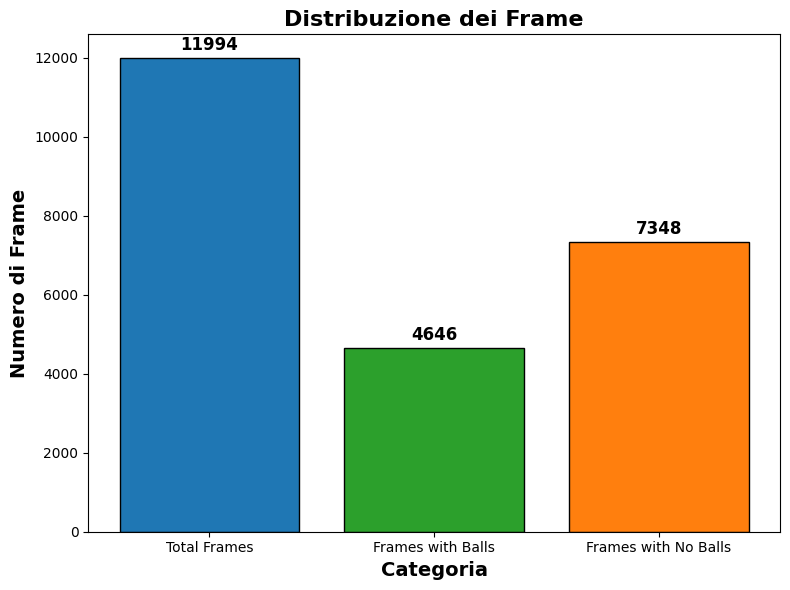

In [5]:
import matplotlib.pyplot as plt

total_frames = len(aggregated_data)
frames_with_target_balls = count_ball
frames_with_target_no_balls = count_no_ball

labels = ['Total Frames', 'Frames with Balls', 'Frames with No Balls']
values = [total_frames, frames_with_target_balls, frames_with_target_no_balls]

fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(labels, values, color=['#1f77b4', '#2ca02c', '#ff7f0e'], edgecolor='black')

for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval + 100,
            f'{yval}', ha='center', va='bottom', fontsize=12, color='black', fontweight='bold')

ax.set_xlabel('Categoria', fontsize=14, fontweight='bold')
ax.set_ylabel('Numero di Frame', fontsize=14, fontweight='bold')
ax.set_title('Distribuzione dei Frame', fontsize=16, fontweight='bold')

plt.tight_layout()

plt.show()

Notiamo che vi è un dataset sbilanciato, infatti abbiamo circa 3K immagini di differenza etichettate come no-balls, questo ci suggerisce la necessità di un eventuale data-augmentation in quanto se abbiamo troppi frame senza palla, il modello potrebbe imparare a prevedere l'assenza di palloni, ignorando la rilevazione effettiva.

## SALVATAGGIO DATASET TEMPORANEO

In [6]:
import json

print("Starting saving...")
path_tempdata_file = "/kaggle/working/data.json"
with open(path_tempdata_file, 'w') as json_file:
    json.dump(aggregated_data, json_file, indent=4)
    
print(f"TempDataset saved in:{path_tempdata_file}")
print("Starting loading tempdata...")

with open( path_tempdata_file, 'r') as json_file:
    data = json.load(json_file) 
print("TempDataset loaded.")

Starting saving...
TempDataset saved in:/kaggle/working/data.json
Starting loading tempdata...
TempDataset loaded.


In [7]:
# PROVA DI VISUALIZZAZIONE 
data[3141]

{'num_frame': 143,
 'target': 'balls',
 'id': 2,
 'pos': [[486.14, 206.75]],
 'track_id': ['2'],
 'outside': [0],
 'occluded': [1],
 'used_in_game': [1]}

Il modello cui faremo riferimento [FASTER R-CNN] usa il formato del dataset pari a **COCO-Dataset**.

Tale formato è organizzato in un file JSON che contiene diverse sezioni principali:

    1) Images: Contiene informazioni sulle immagini, come l'ID, il nome del file, la larghezza e l'altezza;

    2) Annotations: Contiene le annotazioni per gli oggetti presenti nelle immagini. Ogni annotazione ha informazioni come l'ID dell'oggetto, l'ID dell'immagine, la categoria dell'oggetto (nel nostro caso "balls") e le coordinate delle bounding box;

    2) Categories: Elenco delle categorie di oggetti con un ID e un nome associato.

## TRASFROMAZIONE IN COCO-DATASET

In [8]:
import os
from PIL import Image
import json

def create_coco_dataset_from_dicts(dataset_path, annotations, output_json, radius=13):
    
    """
    Crea un dataset nel formato COCO a partire da una lista di dizionari.

    :Params:
        dataset_path: Percorso alla cartella contenente le immagini;
        annotations: Dataset in input;
        output_json: Nome del file di output in formato COCO;
        radius: Raggio per calcolare il bounding box intorno alla palla.
    """
    coco_format = {
        "images": [],
        "annotations": [],
        "categories": [{"id": 1, "name": "balls"}]
    }
    
    print("Starting creating dataset...")
    
    ann_id = 1
    for annotation in annotations:
        
        num_frame = annotation['num_frame']
        target = annotation['target']
        positions = annotation['pos']
        video_id = annotation['id']

        # Generiamo il nome del file come ID-1/frame_1.jpg
        frame_name = f"ID-{video_id}/frame_{num_frame}.jpg"
        frame_path = os.path.join(dataset_path, frame_name)

        frame_width, frame_height = (1920,1080) if video_id in [3,4] else (1920,1088)

        if os.path.exists(frame_path):
            
            image_id = len(coco_format["images"])
            coco_format["images"].append({
                "id": image_id,
                "file_name": frame_path,
                "width": frame_width,
                "height": frame_height
            })

            if target == "balls" and positions:
                for position in positions:
                    
                    center_x, center_y = position
                    
                    # Verifichiamo che la bounding box non fuoriesca dall'immagine
                    xmin = max(0, center_x - radius)
                    ymin = max(0, center_y - radius)
                    xmax = min(frame_width, center_x + radius)
                    ymax = min(frame_height, center_y + radius)

                    # W e H della bounding box
                    width = xmax - xmin
                    height = ymax - ymin

                    coco_format["annotations"].append({
                        "id": ann_id,
                        "image_id": image_id,
                        "category_id": 1,
                        "bbox": [xmin, ymin, xmax, ymax],
                        "area": width * height,
                        "iscrowd": 0,  # Un parametro richiesto per COCO ma non rilevante per i nostri scopi
                        "center": [center_x, center_y]
                    })
                    ann_id += 1

    print(f"Saving dataset in format COCO as file JSON in: {output_json}")
    
    with open(output_json, 'w') as f:
        json.dump(coco_format, f, indent=4)
        
    print(f"Saved dataset in format COCO as file JSON in: {output_json}")

dataset_path = "/kaggle/input/computer-vision-futbal/dataset/dataset/training"
annotations = data
output_json = "/kaggle/working/dataset_coco.json"

create_coco_dataset_from_dicts(dataset_path, annotations, output_json)

Starting creating dataset...
Saving dataset in format COCO as file JSON in: /kaggle/working/dataset_coco.json
Saved dataset in format COCO as file JSON in: /kaggle/working/dataset_coco.json


### VISUALIZZAZIONE DELLE BOUNDING BOX

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


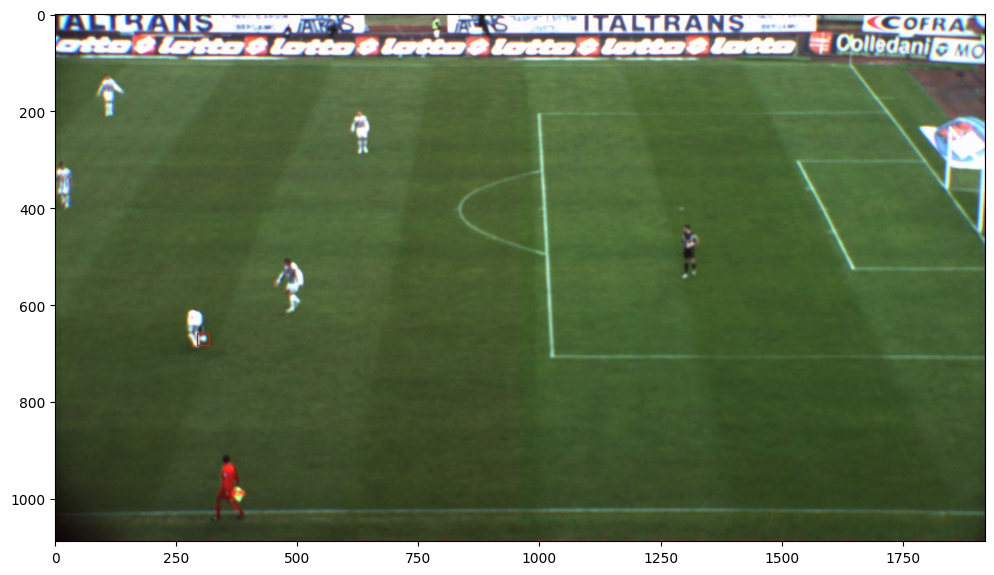

In [9]:
import torch
from torchvision.datasets import CocoDetection
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image

def show_image_with_bboxes(coco_json_path, images_dir, image_index=0):
    """
        Questo metodo genera l'immagine con la relativa bb

        :Params:
            : coco_json_path = raprpesenta il path relativo al dataset in formato COCO;
            :images_dir = rappresenta la cartella contenente le immagini di training;
            :image_index = rappresenta l'indice nel file COCO dell'immagine che si vuole visualizzare.
    """

    dataset = CocoDetection(root=images_dir, annFile=coco_json_path)
    
    img, targets = dataset[image_index]

    fig, ax = plt.subplots(1, figsize=(12, 9))

    ax.imshow(img)

    for target in targets:
        bbox = target['bbox']  # [x_min, y_min, x_max, y_max]
        x_min, y_min, x_max, y_max = bbox
        
        width = x_max - x_min
        height = y_max - y_min

        ax.add_patch(Rectangle((x_min, y_min), width, height, linewidth=1, edgecolor='r', facecolor='none'))

    plt.show()

coco_json_path = '/kaggle/working/dataset_coco.json'
images_dir = '/kaggle/input/computer-vision-futbal/dataset/dataset/training/'

show_image_with_bboxes(coco_json_path, images_dir, image_index=162)

Questi 4 link servono per la funzione di collate

In [10]:
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

0

Andiamo a vedere quanti frame presentano l'annotazione e quanti no.

In [11]:
from pycocotools.coco import COCO
from torchvision.datasets import CocoDetection

annotation_file = '/kaggle/working/dataset_coco.json'

with open(annotation_file, 'r') as f:
    data = json.load(f)

annotated_images = set()
for annotation in data['annotations']:
    annotated_images.add(annotation['image_id'])

image_ids = set(image['id'] for image in data['images'])

with_annotations = len(annotated_images)
without_annotations = len(image_ids - annotated_images)

print(f"Frames with annotations: {with_annotations}")
print(f"Frames without annotations: {without_annotations}")


Frames with annotations: 4646
Frames without annotations: 7348


Confermiamo la tesi che vi è bisono di data augmentation.

## DATASET CUSTOM

In [12]:
import torch
import os
from pycocotools.coco import COCO
from PIL import Image, ImageOps
import torchvision.transforms as T
import os
import torch
import json
from torchvision.io import read_image
from torchvision.ops.boxes import box_area
from torchvision.transforms.v2 import functional as F
import random
import torch
import PIL
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage


class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root, annotation, transform):
        """
        Dataset peronalizzato in questo modo possiamo usarlo con il dataloader.

        :Params:
            :root = Il path alla cartella che contiene le immagini;
            :annotation = Il file di annotazione in formato COCO;
            :transform = Trasformazione da applicare alle immagini e bounding box.
        """
        self.root = root
        self.coco = COCO(annotation)
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.transform = transform

    def __getitem__(self, index):
        img_id = self.ids[index]
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)
        path = self.coco.loadImgs(img_id)[0]['file_name']
        
        img_path = os.path.join(self.root, path)
        PIL_image = PIL.Image.open(img_path)
        img = torchvision.transforms.functional.to_tensor(PIL_image)
        
        num_objs = len(anns)
        if num_objs == 0:
            #Se l'annotazione non è presente allora la palla non è nell'immagine e creaiamo un target vuoto
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
            area = torch.zeros((0,), dtype=torch.float32)
            iscrowd = torch.zeros((0,), dtype=torch.int64)
        else:
            boxes = []
            for i in range(num_objs):
                
                xmin = anns[i]['bbox'][0]
                ymin = anns[i]['bbox'][1]
                xmax = anns[i]['bbox'][2]
                ymax = anns[i]['bbox'][3]
                
                boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        area = torch.tensor([obj['area'] for obj in anns], dtype=torch.float32)
        category = torch.tensor([obj['category_id'] if 'category_id' in obj else 0 for obj in anns], dtype=torch.int64)
        iscrowd = torch.tensor([obj['iscrowd'] if 'iscrowd' in obj else 0 for obj in anns], dtype=torch.int64)

        target={}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = torch.tensor([index])
        target["area"] = area
        target["iscrowd"] = iscrowd
        target['category'] = category

        C, H, W = img.shape

        if H>1080:
            #Croppiamo l'immagine e le bounding box cosi da avere immagini omogonee
            img, target = self.cut_img_boxes(img, target)
        
        if self.transform:
            #Applichiamo le trasformazioni passate in input
            img,target = self.transform(img,target)

        
        """[PER DEBUG]
        print("Showing pictures")

        mean = torch.tensor([0.485, 0.456, 0.406])
        std = torch.tensor([0.229, 0.224, 0.225])
        img = img * std[:, None, None] + mean[:, None, None]

        new_PIL_image = torchvision.transforms.functional.to_pil_image(img)

        pil_img = draw_bounding_boxes(new_PIL_image, target["boxes"])

        plt.imshow(pil_img)
        plt.show()
        """
    
        return img, target

    def __len__(self):
        return len(self.ids)

    def cut_img_boxes(self, img, target):
      cropped_image = img[:, 4:1084, :] #Slicing dell'immagine (C, 4:1084, W) -> Crop 4 pixel in alto e 4 in basso

      if len(target["boxes"]) > 0:
          boxes = target["boxes"]

          # Adattiamo le bounding box per il cropping
          boxes[:, 1] = boxes[:, 1] - 4
          boxes[:, 3] = boxes[:, 3] - 4

          boxes[:, 1] = boxes[:, 1].clamp(min=0) 
          boxes[:, 3] = boxes[:, 3].clamp(max=1080)

          target["boxes"] = boxes

      return cropped_image, target

### TRASFORMAZIONI PERSONALIZZATE

Quando si lavora con **TorchVision** per applicare trasformazioni su immagini e target contemporaneamente, bisogna fare attenzione al fatto che molte trasformazioni (come Resize, RandomCrop, Normalize, ecc.) non si applicano direttamente sia alle immagini che ai target contemporaneamente, in quanto le trasformazioni si aspettano che l'input sia solo un'immagine, mentre i target (ad esempio, le bounding boxes nel nostro caso) sono strutture separate. Quindi è sorto il bisogno di definire delle trasformazioni personalizzate.
Si potrebbe usare la nuova versione di torchvision, che fornisce delle trasformazioni che gestiscono l'applicazione delle trasformazioni sia alle immagini che ai bounding box contemporaneamente, ma ad esempio il tipo tv_tensor viene richiesto poi anche in una successiva fase di inferenza, altrimenti il modello non riesce ad elaborare l'immagine. Per il nostro obiettivo andiamo a definire delle trasformazioni personalizzate.

In [13]:
import random
import torch
from torchvision.transforms import functional as F
from PIL import Image
from torchvision import tv_tensors
from torchvision.transforms import v2
import os
from pycocotools.coco import COCO
from torchvision.io import read_image
from torchvision.ops.boxes import box_area

def apply_random_horizontal_flip_tensor(image, target, p=0.5):
    if random.random() < p:

        image = F.hflip(image)
        
        width = image.shape[-1]
        target["boxes"][:, [0, 2]] = width - target["boxes"][:, [2, 0]]
        
    return image, target

def apply_random_vertical_flip_tensor(image, target, p=0.5):
    if random.random() < p:
        image = F.vflip(image)
        
        height = image.shape[-2] 
        target["boxes"][:, [1, 3]] = height - target["boxes"][:, [3, 1]]
    return image, target

class RandomHorizontalFlipTensor:
    def __init__(self, p=0.5):
        self.p = p
    
    def __call__(self, image, target):
        return apply_random_horizontal_flip_tensor(image, target, self.p)

class RandomVerticalFlipTensor:
    def __init__(self, p=0.5):
        self.p = p
    
    def __call__(self, image, target):
        return apply_random_vertical_flip_tensor(image, target, self.p)
        
class RandomBothFlipTensor:
    def __init__(self, p=0.5):
        self.p = p
    
    def __call__(self, image, target):
        image, target =  apply_random_vertical_flip_tensor(image, target, self.p)
        return apply_random_horizontal_flip_tensor(image,target, self.p)
        
class ComposeWithTarget:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for transform in self.transforms:
            image, target = transform(image, target)
        return image, target

transform_pipeline = ComposeWithTarget([
    lambda img, target: random.choice([
        RandomHorizontalFlipTensor(p=1),
        RandomVerticalFlipTensor(p=1),
        RandomBothFlipTensor(p=1),
    ])(img, target),
    lambda img, target: (v2.ToPureTensor()(img), target),
    lambda img, target: (v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(img), target)
])

transform_nom = v2.Compose([
    lambda img, target: (v2.ToPureTensor()(img), target),
    lambda img, target: (v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(img), target)
])

# MODELLO FASTER R-CNN

Il modello Faster R-CNN è una delle architetture più popolari per l'object detection. Le principali motivazioni che ci hanno spinto alla scelta di questo modello sono le seguenti: 
1. RPN: Faster R-CNN combina l'accuratezza dell'approccio R-CNN con un miglioramento significativo in termini di velocità. L'architettura integra per la prima volta, un modulo chiamato Region Proposal Network (RPN) che genera regioni di interesse (RoI) proposte direttamente dalla rete. Questo elimina la necessità di utilizzare metodi esterni come Selective Search (usato in R-CNN e Fast R-CNN) che sono costosi in termini di tempo e risorse computazionali. Con tale tecnica, Faster R-CNN può elaborare le immagini in modo più veloce, mantenendo al contempo un'alta precisione nell'identificazione degli oggetti;
2. La RPN è progettata per generare proposte di regioni di interesse (RoI) molto più precise e accurate rispetto ad altri metodi tradizionali, come Selective Search. In questo modo, il modello riduce sia il numero di proposte inutili che il numero di false rilevazioni, migliorando l'affidabilità del sistema di object detection;
3. Supporta la multi-class object detection, ovvero la possibilità di riconoscere diverse categorie di oggetti all'interno della stessa immagine.

La rete viene inizializzata utilizzando la versione ResNet-50 come backbone e una Feature Pyramid Network (FPN). Poichè la rete è pre-addestrata su COCO che presenta 91 classi, per poterla ri-adattare al nostro task, che è l'individuazione della palla, dobbiamo andare a modificare il blocco di classificazione, in quanto le classi di output sono 2, palla + sfondo.
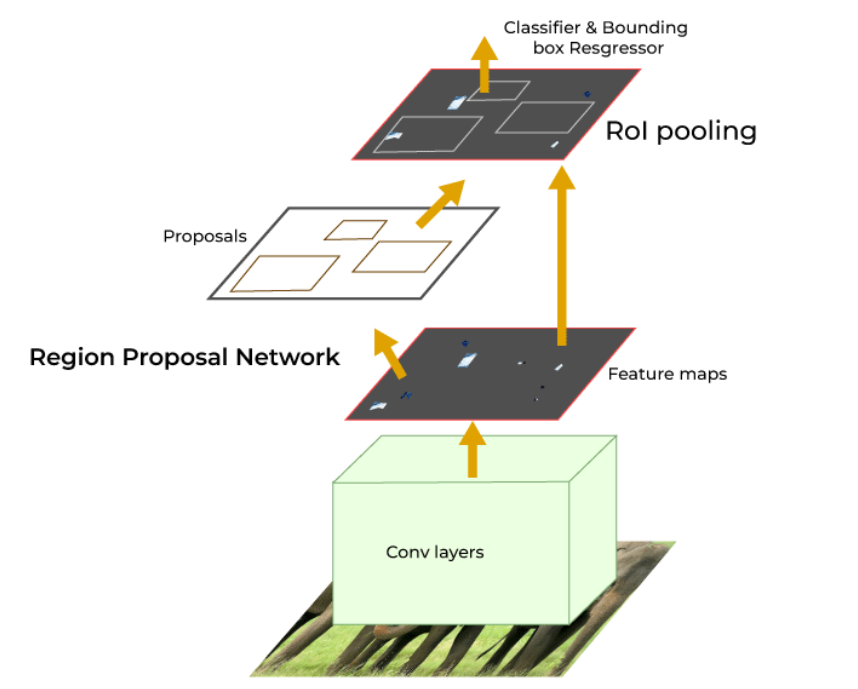
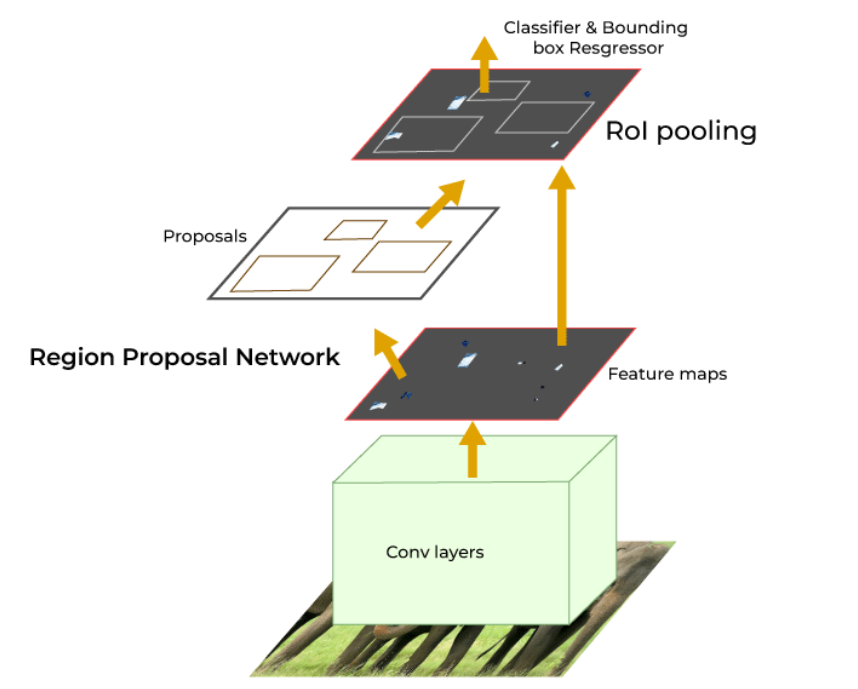
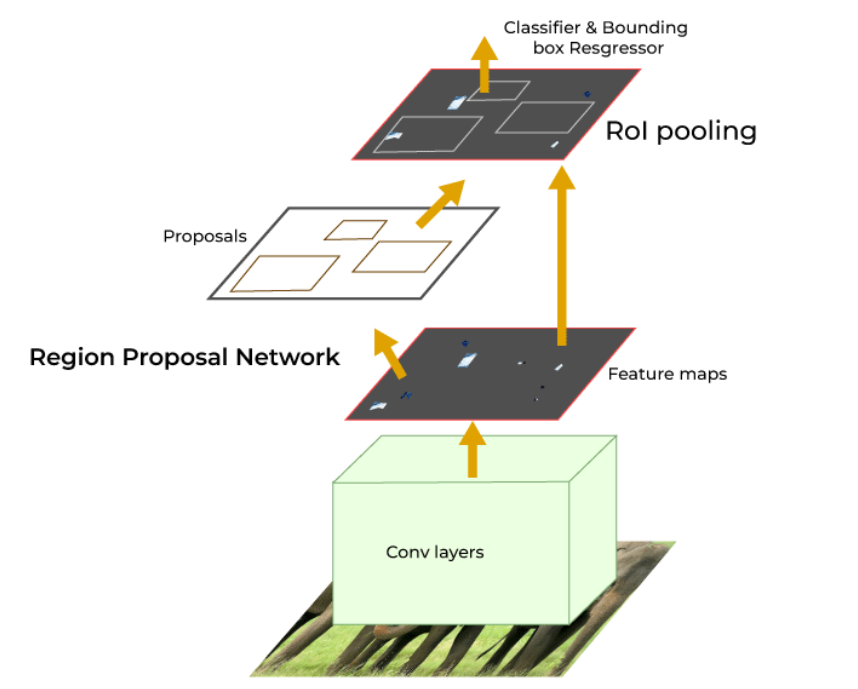
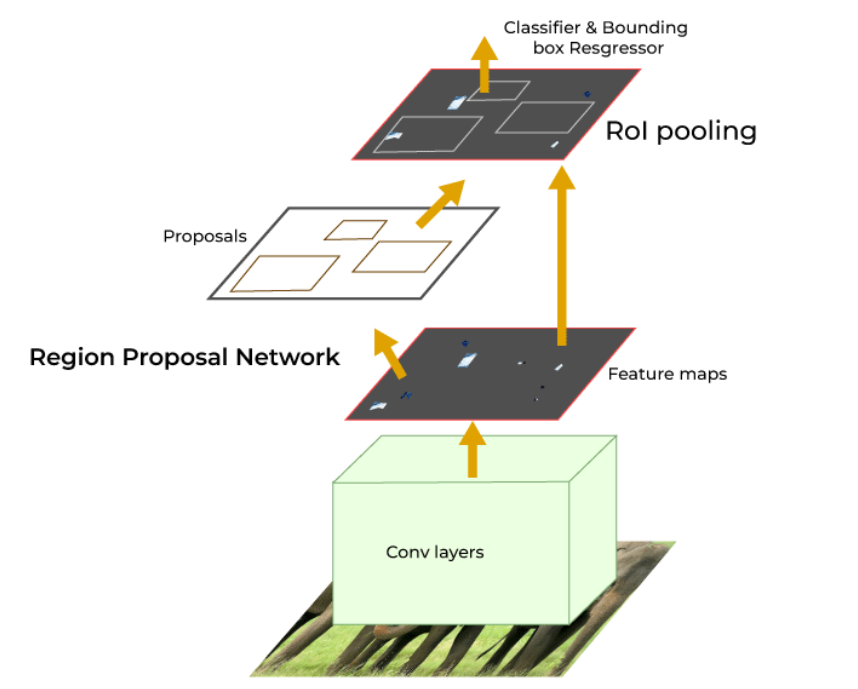
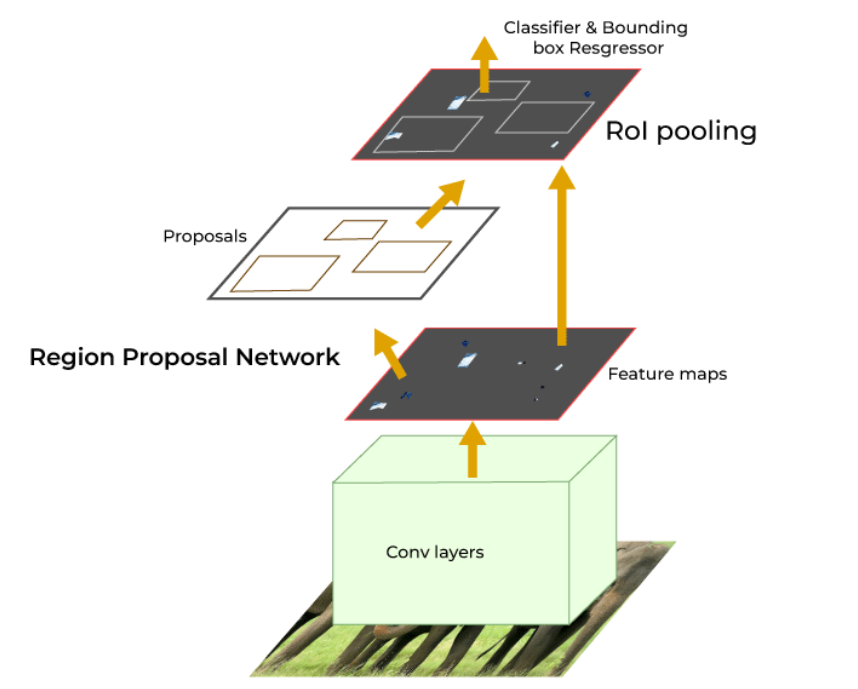

In [14]:
from functools import partial
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_the_model(num_classes = 2):
    """
        Metodo per la creazione del modello

        :Params:
            : num_classes = rappresenta il numero di classi di output desiderate. 
    """
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights="DEFAULT")
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features,num_classes)
    return model

## ADDESTRAMENTO & VALIDAZIONE

In [15]:
def train_one_epoch(model_name, model, optimizer, data_loader, device, epoch, num_total_epoch):

    """
        Metodo di addestramento per una sola epoca. 

        :Params:
            :model_name = Rappresenta il nome del modello, utile per il salvataggio;
            :model = Rappresenta il modello inizializzato;
            :optimizer = L'ottimizzatore utilizzato per l'addestramento;
            :data_loader = Il dataset suddiviso in batch:
            :epoch = L'epoca di riferimento;
            :device = Dispositivo usato (CPU o GPU)
            :num_total_epoch = Il numero totale di epoche.
            
        :Returns:
            :train_loss_list = La lista dei valori di loss valutati per ogni batch.
    """
    model.train()

    train_loss_list = []
  
    total_loss = 0

    for i, (images, targets) in enumerate(data_loader):

        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images,targets)
    
        losses = sum(loss for loss in loss_dict.values())
    
        total_loss += losses.item()
        train_loss_list.append(losses.item())
    
        if i % 100 == 0:
            print(f"\nEpoch [{epoch+1}/{num_total_epoch}], Batch [{i+1}/{len(data_loader)}], Total Loss: {losses.item()}")
    
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
    

    avg_loss = total_loss / len(data_loader)
    print(f"\nEpoch [{epoch+1}/{num_total_epoch}] completed. Average Total Loss: {avg_loss}")

    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': losses,
      }, f'/kaggle/working/{model_name}_finetuned_epoch-{epoch+1}.pth')
    
    print(f"\n Model for epoch:{epoch+1} saved in: /kaggle/working/{model_name}_finetuned_epoch-{epoch+1}.pth")

    return train_loss_list

In [16]:
def evaluate(model, data_loader_test, device):

    """
        Metodo di validazione, eseguito su una piccola porzione di dataset.

        :Params:
            :Model = rappresenta il modello inizializzato pronto all'uso;
            :data_loader_test = Rappresenta il dataset di validazione suddiviso in batch;
            :device = Il dispositivo in uso (CPU o GPU);
            
        :Returns:
            :val_loss_list = La lista delle loss per ogni batch di validazione.
    """
    
    val_loss_list = []

    for i, data in enumerate(data_loader_test):
        images, targets = data

        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        with torch.no_grad():
            losses = model(images, targets)

        loss = sum(loss for loss in losses.values())
        loss_val = loss.item()
        val_loss_list.append(loss_val)

        if i % 100 == 0:
            print(f"\nValidation Batch [{i+1}/{len(data_loader_test)}], Validation Loss: {loss_val}")
        
    avg_loss = sum(val_loss_list) / len(data_loader_test)
    print(f"Validation completed. Average Total Loss: {avg_loss}")

    return val_loss_list

In [17]:
import pickle

def train_model(model_name, model, optimizer, data_loader, val_loader, device, num_total_epoch, output_directory):
    """
        Richiama train_one_epoch e evaluatte per un numero specificato di epoche, salvando i dati di perdita dopo ogni epoca.

        :Params:
            :model_name = Il nome del modello, utilizzato per salvare i checkpoint del modello;
            :model = Il modello da usare;
            :optimizer = L'ottimizzatore utilizzato per aggiornare i pesi del modello;
            :data_loader = Il dataset di train suddiviso in batch;
            :val_loader = Il dataset di validazione suddiviso in batch;
            :device = Il dispositivo in uso (CPU o GPU);
            :num_total_epoch = Il numero totale di epoche;
            :output_directory = Il percorso della directory in cui verranno salvati i checkpoint del modello.
    """
    
    loss_dict = {'train_loss': [], 'valid_loss': []}

    for epoch in range(num_total_epoch):

        print(f"\nStarting Training for {epoch+1}/{num_total_epoch}")

        train_loss_list = train_one_epoch(model_name, model, optimizer, data_loader, device, epoch, num_total_epoch)

        loss_dict['train_loss'].extend(train_loss_list)

        print(f"\nStarting Validation for {epoch+1}/{num_total_epoch}")

        val_loss_list = evaluate(model, val_loader, device)

        loss_dict['valid_loss'].extend(val_loss_list)

    #Cosi poi possiamo farci il plot delle varie loss
    with open(f"{output_directory}/loss_dict_{model_name}.pkl", "wb") as file:
        pickle.dump(loss_dict, file)

    print("Training completed.")


In [18]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

def plot_loss(file_path, num_epoch):
    
    """
        Carica i dati di perdita salvati in un file pickhle, calcola la perdita media per ogni epoca, 
        e visualizza un grafico che confronta la perdita di training e validazione nel corso delle epoche.

        :Params:
            :file_path = Il percorso del file pickle contenente i dati di perdita (train_loss e valid_loss);
            :num_epoch = Numero delle epoche.
    """

    with open(file_path, 'rb') as file:
        data = pickle.load(file)

    num_epochs = num_epoch

    def calculate_epoch_losses(loss_data):
        """
            Calcola la loss per ogni epoca.
        """
        values_per_epoch = len(loss_data) // num_epochs
        epoch_losses = []
        for i in range(num_epochs):
            start_idx = i * values_per_epoch
            end_idx = (i + 1) * values_per_epoch
            epoch_loss = np.mean(loss_data[start_idx:end_idx])
            epoch_losses.append(epoch_loss)
        return epoch_losses

    valid_loss_mean = calculate_epoch_losses(data['valid_loss'])
    train_loss_mean = calculate_epoch_losses(data['train_loss'])

    epochs = range(1, num_epochs + 1)

    plt.figure(figsize=(12, 8))

    plt.plot(epochs, valid_loss_mean, label='Valid Loss', color='royalblue', marker='o', linestyle='-', linewidth=3, markersize=8)
    plt.plot(epochs, train_loss_mean, label='Train Loss', color='tomato', marker='s', linestyle='--', linewidth=3, markersize=8)

    plt.xlabel('Epoca', fontsize=16, fontweight='bold', color='darkslategray')
    plt.ylabel('Loss Media', fontsize=16, fontweight='bold', color='darkslategray')
    plt.title('Confronto tra Media delle Loss per Epoca (Train vs Valid)', fontsize=18, fontweight='bold', color='darkred')

    plt.xticks(fontsize=12, fontweight='bold', color='darkslategray')
    plt.yticks(fontsize=12, fontweight='bold', color='darkslategray')

    plt.legend(fontsize=14)

    plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
    
    plt.gca().set_facecolor('whitesmoke')

    #Cosi mettiamo il tag sull'epoca 5
    plt.scatter(5, valid_loss_mean[4], color='green', s=100, label="Modello Ottimale (Epoca 5)", edgecolors='black', zorder=5)
    plt.scatter(5, train_loss_mean[4], color='green', s=100, marker='*', edgecolors='black', zorder=5)

    plt.tight_layout()
    plt.show()

## SPLIT VAL E TRAIN

Data Augment verrà fatto solo per le istanze senza palla, quindi ci andiamo ad estrarre le istanze che contengono la palla.

In [19]:
with open('/kaggle/working/dataset_coco.json', 'r') as f:
    dataset = json.load(f)

annotated_image_ids = set([annotation['image_id'] for annotation in dataset['annotations']])
images_with_annotations = [image for image in dataset['images'] if image['id'] in annotated_image_ids]
annotations_for_filtered_images = [annotation for annotation in dataset['annotations'] if annotation['image_id'] in annotated_image_ids]

new_dataset = {
    'images': images_with_annotations,
    'annotations': annotations_for_filtered_images,
    'categories': dataset['categories']
}

with open('filtered_only_annotated_dataset.json', 'w') as f:
    json.dump(new_dataset, f, indent=4)

In [20]:
annotation_file = '/kaggle/working/filtered_only_annotated_dataset.json'

with open(annotation_file, 'r') as f:
    data = json.load(f)

annotated_images = set()
for annotation in data['annotations']:
    annotated_images.add(annotation['image_id'])

image_ids = set(image['id'] for image in data['images'])
with_annotations = len(annotated_images)
without_annotations = len(image_ids - annotated_images)

print(f"Frames with annotations: {with_annotations}")
print(f"Frames without annotations: {without_annotations}")

Frames with annotations: 4646
Frames without annotations: 0


## CREAZIONE DATALOADER

In [21]:
from torch.utils.data import ConcatDataset

data_path = '/kaggle/input/computer-vision-futbal/dataset/dataset/training'
annotation_path_train = '/kaggle/working/dataset_coco.json'
save_result_path = '/kaggle/working/'
annotation_data_to_augment_path_train = '/kaggle/working/filtered_only_annotated_dataset.json'

dataset_augmented =  CustomDataset(data_path, annotation_data_to_augment_path_train, transform = transform_pipeline)
dataset_normalizzato =  CustomDataset(data_path, annotation_path_train, transform = transform_nom)
concated_dataset = ConcatDataset([dataset_normalizzato, dataset_augmented])

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


In [22]:
import torch
from torch.utils.data import random_split
import utils

train_percentage = 0.8 
val_percentage = 0.2 
batch_size = 4

total_size = len(concated_dataset)
train_size = int(train_percentage * total_size)

val_size = total_size - train_size

generator = torch.Generator().manual_seed(42)

train_set, val_set = random_split(concated_dataset, [train_size, val_size], generator=generator)

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle= True,
    num_workers=4,
    collate_fn=utils.collate_fn,
    drop_last=False
)

val_loader = torch.utils.data.DataLoader(
    val_set,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    collate_fn=utils.collate_fn,
    drop_last=False
)

# TRAIN

In [23]:
import torchvision

model_name = "FASTER-R-CNN"

num_classes = 2 #[Palla e Background]
model = get_the_model(num_classes)

optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
num_total_epoch = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device -> {device}")

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth
100%|██████████| 167M/167M [00:00<00:00, 189MB/s]


Device -> cpu


In [24]:
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

In [25]:
len(train_loader)

3328

In [26]:
len(val_loader)

832

In [27]:
#train_model(model_name = model_name, model = model, optimizer = optimizer, data_loader = train_loader, val_loader = val_loader, device = device, num_total_epoch = num_total_epoch, output_directory = save_result_path)

## PLOT GRAFICO LOSS E SCELTA DEL MODELLO

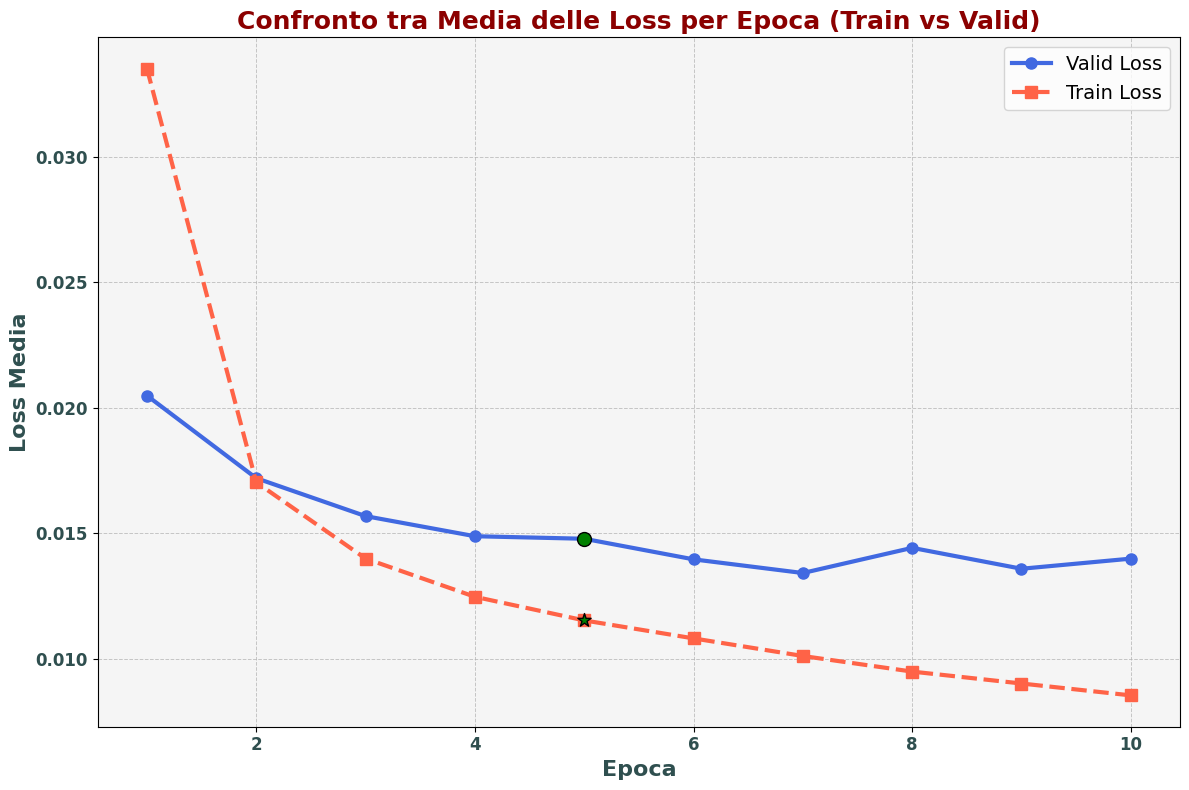

In [28]:
file_path = '/kaggle/input/result-faster-r-cnn/loss_dict_FASTER-R-CNN.pkl'
plot_loss(file_path, num_epoch = num_total_epoch)

Analizzando attentamente le epoche si potrebbe pensare che quella migliore sia la 6, in quanto dalla 7 epoca la funzione di perdita di validazione tende ad risalire, facendoci sospettare l'inizio di overfitting. Tra il modello 5 e 6 si è scelto il 5, in quanto otteniamo dei risultati migliori in fase di inferenza.